## Курсовой проект


**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline, Pipeline

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
df_train = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

df_train_init, df_test_init = df_train.copy(), df_test.copy()

In [3]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,NaN,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,NaN,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,NaN,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,NaN,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,NaN,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [4]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,NaN
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,NaN,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,NaN,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


### Обработка данных обучающего датасета

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.00,1366391.72,845339.20,164597.00,844341.00,1168386.00,1640137.00,10149344.00
Tax Liens,7500.00,0.03,0.27,0.00,0.00,0.00,0.00,7.00
Number of Open Accounts,7500.00,11.13,4.91,2.00,8.00,10.00,14.00,43.00
Years of Credit History,7500.00,18.32,7.04,4.00,13.50,17.00,21.80,57.70
Maximum Open Credit,7500.00,945153.73,16026216.67,0.00,279229.50,478159.00,793501.50,1304726170.00
Number of Credit Problems,7500.00,0.17,0.50,0.00,0.00,0.00,0.00,7.00
Months since last delinquent,3419.00,34.69,21.69,0.00,16.00,32.00,50.00,118.00
Bankruptcies,7486.00,0.12,0.35,0.00,0.00,0.00,0.00,4.00
Current Loan Amount,7500.00,11873177.45,31926122.97,11242.00,180169.00,309573.00,519882.00,99999999.00
Current Credit Balance,7500.00,289833.24,317871.38,0.00,114256.50,209323.00,360406.25,6506797.00


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [8]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()

In [9]:
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [10]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [11]:
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = df_train['Credit Score'].median()

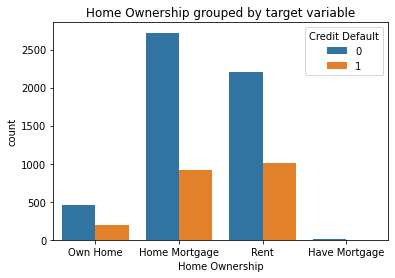

In [12]:
sns.countplot(x='Home Ownership', hue='Credit Default', data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.show()

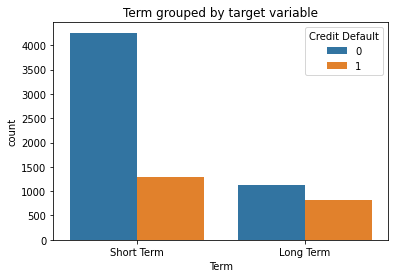

In [13]:
sns.countplot(x='Term', hue='Credit Default', data=df_train)
plt.title('Term grouped by target variable')
plt.show()

In [14]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(cat_colname)
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
    df_train = df_train.drop(cat_colname, axis=1)

Home Ownership
Years in current job
Purpose
Term


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   7500 non-null   float64
 1   Tax Liens                       7500 non-null   float64
 2   Number of Open Accounts         7500 non-null   float64
 3   Years of Credit History         7500 non-null   float64
 4   Maximum Open Credit             7500 non-null   float64
 5   Number of Credit Problems       7500 non-null   float64
 6   Months since last delinquent    7500 non-null   float64
 7   Bankruptcies                    7500 non-null   float64
 8   Current Loan Amount             7500 non-null   float64
 9   Current Credit Balance          7500 non-null   float64
 10  Monthly Debt                    7500 non-null   float64
 11  Credit Score                    7500 non-null   float64
 12  Credit Default                  75

### Обработка данных тестового датасета

In [16]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.00,1366921.68,917125.15,106533.00,852311.50,1178475.00,1629734.50,14975610.00
Tax Liens,2500.00,0.04,0.39,0.00,0.00,0.00,0.00,15.00
Number of Open Accounts,2500.00,11.18,4.85,1.00,8.00,10.00,14.00,48.00
Years of Credit History,2500.00,18.33,7.25,3.90,13.40,17.00,22.10,53.40
Maximum Open Credit,2500.00,710570.41,1511983.48,0.00,278586.00,478676.00,802598.50,54484386.00
Number of Credit Problems,2500.00,0.16,0.56,0.00,0.00,0.00,0.00,15.00
Months since last delinquent,1142.00,34.18,22.02,0.00,16.00,30.00,50.00,82.00
Bankruptcies,2497.00,0.11,0.36,0.00,0.00,0.00,0.00,5.00
Current Loan Amount,2500.00,12155719.63,32260973.72,15422.00,187126.50,322366.00,522582.50,99999999.00
Current Credit Balance,2500.00,296396.65,378301.97,0.00,110114.50,207385.00,366348.50,6030087.00


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [18]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [19]:
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].median()

In [20]:
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [21]:
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [22]:
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test['Credit Score'].median()

In [23]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(cat_colname)
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)
    df_test = df_test.drop(cat_colname, axis=1)

Home Ownership
Years in current job
Purpose
Term


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Tax Liens                       2500 non-null   float64
 2   Number of Open Accounts         2500 non-null   float64
 3   Years of Credit History         2500 non-null   float64
 4   Maximum Open Credit             2500 non-null   float64
 5   Number of Credit Problems       2500 non-null   float64
 6   Months since last delinquent    2500 non-null   float64
 7   Bankruptcies                    2500 non-null   float64
 8   Current Loan Amount             2500 non-null   float64
 9   Current Credit Balance          2500 non-null   float64
 10  Monthly Debt                    2500 non-null   float64
 11  Credit Score                    2500 non-null   float64
 12  Home Ownership_Have Mortgage    25

In [25]:
df_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,1178475.00,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,162470.00,105906.00,...,0,0,0,0,0,0,0,0,0,1
1,231838.00,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,78298.00,46037.00,...,0,0,0,0,0,0,0,0,0,1
2,1152540.00,0.00,10.00,13.70,204600.00,0.00,0.00,0.00,200178.00,146490.00,...,0,0,0,0,0,0,0,0,0,1
3,1220313.00,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,217382.00,213199.00,...,0,0,0,0,0,0,0,0,0,1
4,2340952.00,0.00,11.00,23.60,1207272.00,0.00,0.00,0.00,777634.00,425391.00,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.00,0.00,14.00,29.10,559152.00,1.00,68.00,1.00,99999999.00,162735.00,...,0,0,0,0,0,0,0,0,0,1
2496,1178475.00,0.00,15.00,17.00,1737780.00,0.00,77.00,0.00,468512.00,1439269.00,...,0,0,0,0,0,0,0,0,0,1
2497,1171806.00,0.00,48.00,12.80,1706430.00,0.00,0.00,0.00,430496.00,676438.00,...,0,0,0,0,0,0,0,0,0,1
2498,723520.00,0.00,14.00,28.80,945780.00,0.00,0.00,0.00,257774.00,391248.00,...,0,0,0,0,0,0,0,0,0,1


In [26]:
df_test.insert(loc=37, column='Purpose_renewable energy', value=0)

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Tax Liens                       2500 non-null   float64
 2   Number of Open Accounts         2500 non-null   float64
 3   Years of Credit History         2500 non-null   float64
 4   Maximum Open Credit             2500 non-null   float64
 5   Number of Credit Problems       2500 non-null   float64
 6   Months since last delinquent    2500 non-null   float64
 7   Bankruptcies                    2500 non-null   float64
 8   Current Loan Amount             2500 non-null   float64
 9   Current Credit Balance          2500 non-null   float64
 10  Monthly Debt                    2500 non-null   float64
 11  Credit Score                    2500 non-null   float64
 12  Home Ownership_Have Mortgage    25

### Анализ данных

In [28]:
target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()

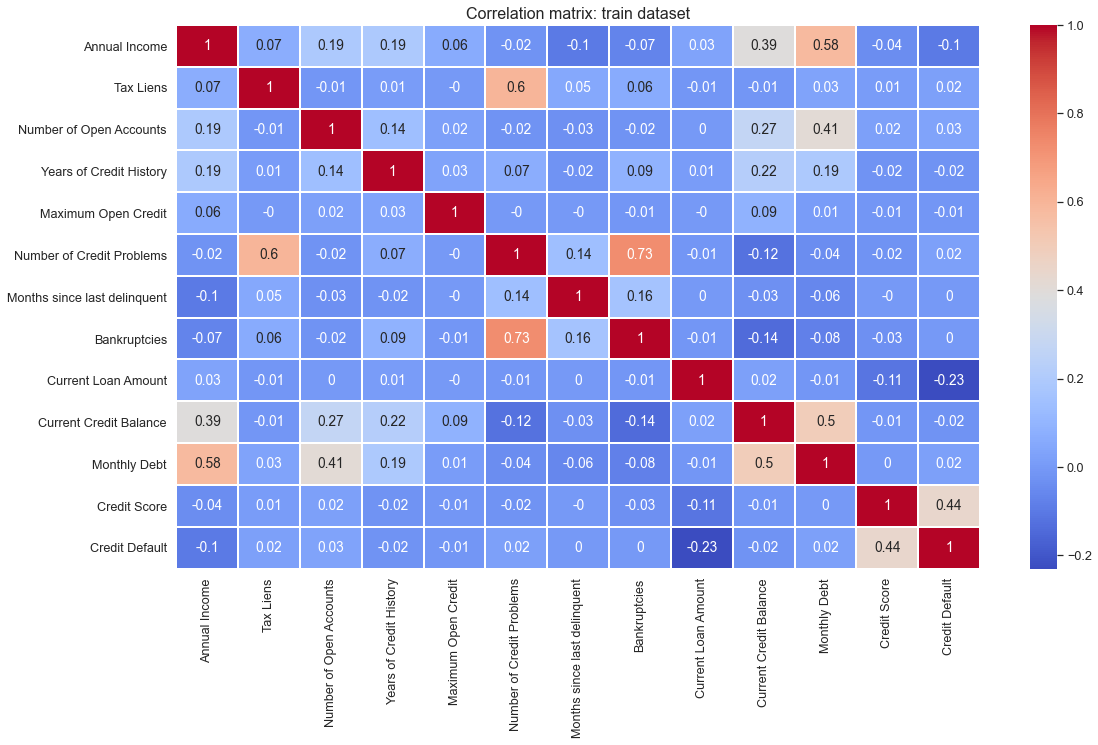

In [29]:
plt.figure(figsize = (18, 10))
sns.set(font_scale=1.15)
sns.heatmap(df_train_init.corr().round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix: train dataset', fontsize=16)
plt.show()

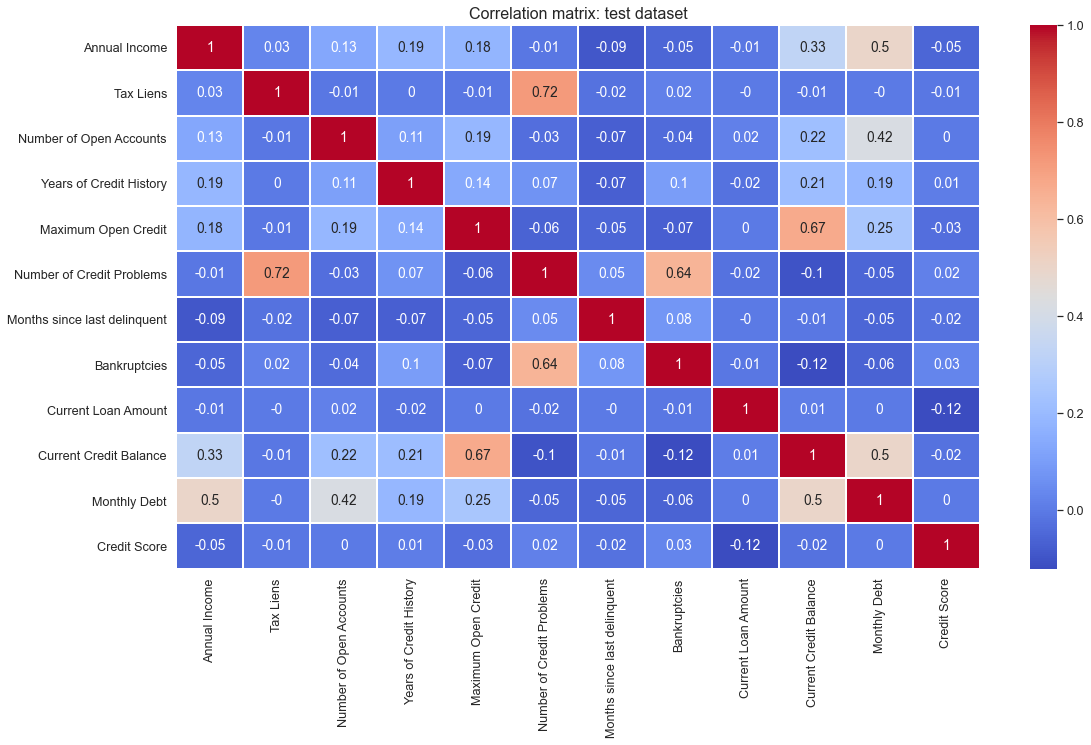

In [30]:
plt.figure(figsize = (18, 10))
sns.set(font_scale=1.15)
sns.heatmap(df_test_init.corr().round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix: test dataset', fontsize=16)
plt.show()

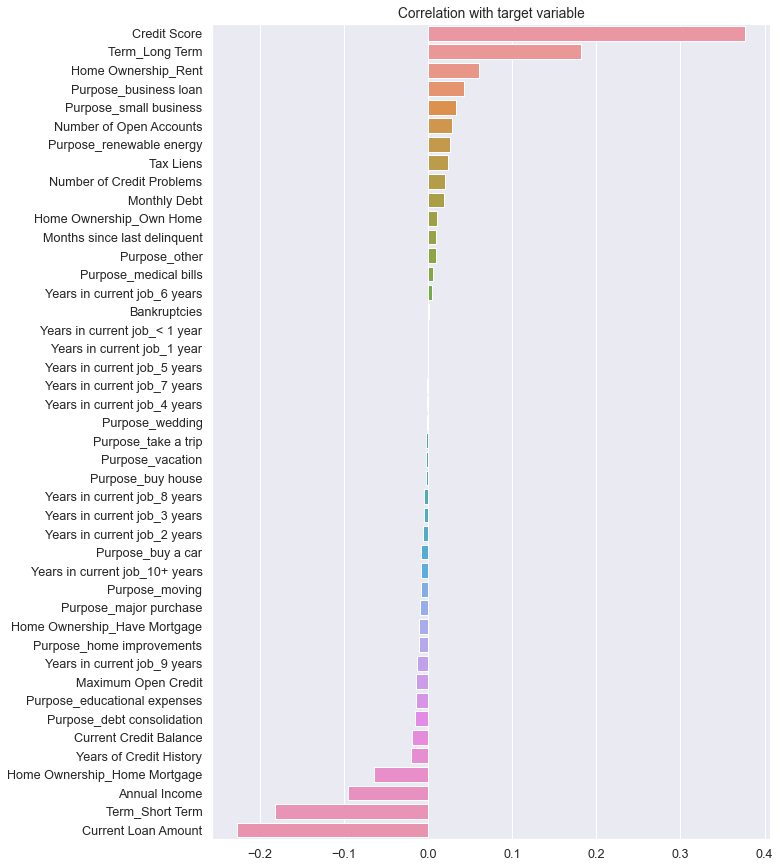

In [31]:
corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

### Подготовка данных

In [32]:
df_train[target_name].value_counts(normalize=True)

0   0.72
1   0.28
Name: Credit Default, dtype: float64

In [33]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [34]:
df_train_balanced = balance_df_by_target(df_train, target_name)

df_train_balanced[target_name].value_counts(normalize=True)

0   0.56
1   0.44
Name: Credit Default, dtype: float64

In [35]:
# scaler = StandardScaler()
# df_train_balanced_normalized = scaler.fit_transform(df_train_balanced)

### Обучение модели 

In [36]:
X = df_train_balanced[feature_names]
y = df_train_balanced[target_name]

In [37]:
model = catb.CatBoostClassifier(silent=True, random_state=42)

In [38]:
parameters = {'n_estimators': [100, 500, 1000, 2000, 5000],
          'max_depth': [3, 5, 7, 10],
          'l2_leaf_reg': [0.01, 0.1, 1, 10]
         }

In [39]:
rscv = RandomizedSearchCV(model, parameters, scoring='f1', cv=KFold(n_splits=3, random_state=42, shuffle=True), 
                          verbose=4, n_jobs=-1)

In [40]:
# rscv.fit(X, y)

In [41]:
# rscv.best_params_

In [42]:
# rscv.best_score_

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

In [44]:
scale = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0]

In [45]:
final_model = catb.CatBoostClassifier(n_estimators=10000, max_depth=10, l2_leaf_reg=0.1, scale_pos_weight=scale, 
                                      silent=True, random_state=42)

final_model.fit(X_train, y_train)

In [46]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

In [47]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [48]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3710
           1       1.00      1.00      1.00      3019

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1677
           1       0.82      0.85      0.84      1207

    accuracy                           0.86      2884
   macro avg       0.85      0.86      0.86      2884
weighted avg       0.86      0.86      0.86      2884

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1448   229
1                176  1031


In [49]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

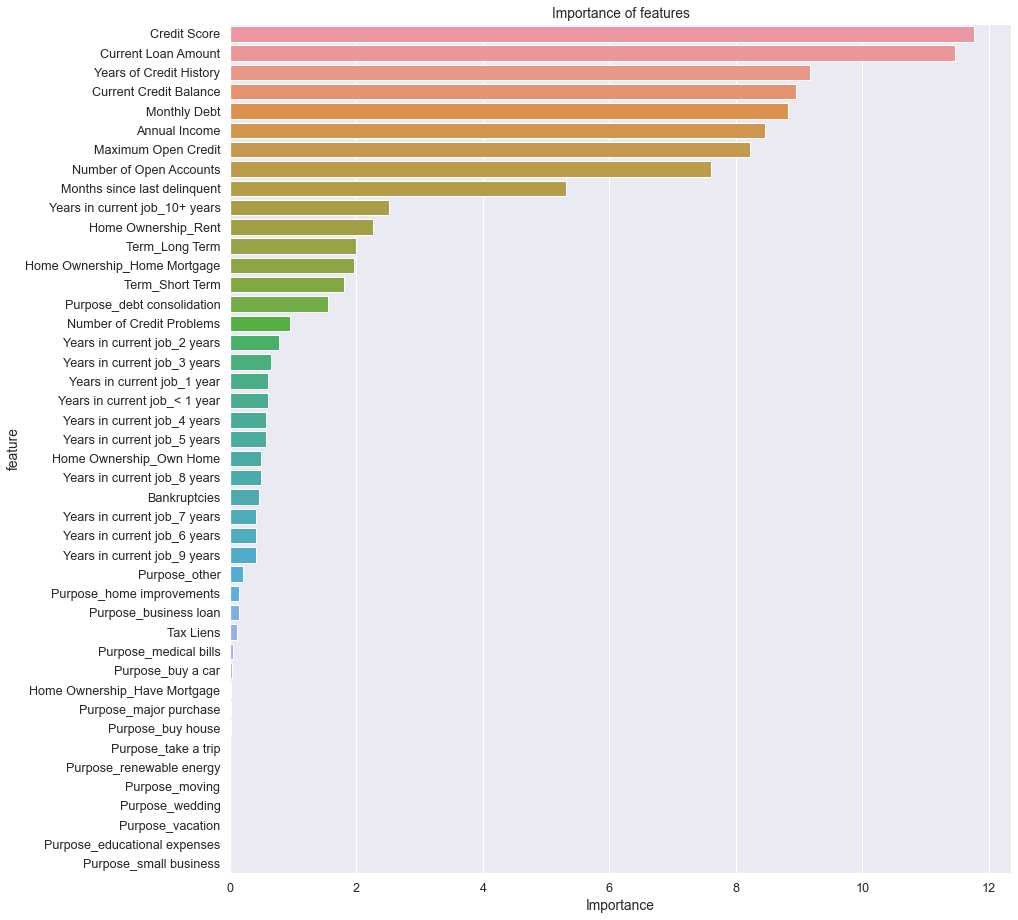

In [50]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  final_model.feature_importances_, 
                                                  get_top=15)

In [51]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])
    plt.show()

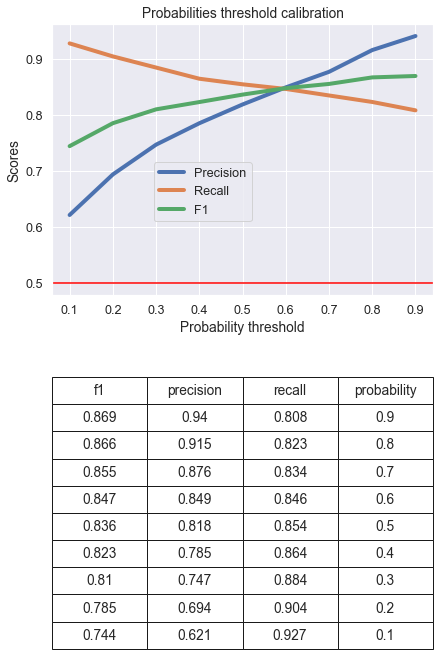

In [52]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Целевая метрика F1 достигает максимума при пороге вероятности 0.9 с учетом ограничений precision > 0.5 и recall > 0.5

In [53]:
threshold = 0.9

In [54]:
y_test_pred_probs.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [55]:
y_test_final_pred = y_test_pred_probs[:, 1].copy()

y_test_final_pred[y_test_final_pred >= threshold] = 1
y_test_final_pred[y_test_final_pred < threshold] = 0

In [56]:
sum(y_test_pred != y_test_final_pred)

223

In [57]:
get_classification_report(y_train, y_train_pred, y_test, y_test_final_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3710
           1       1.00      1.00      1.00      3019

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1677
           1       0.94      0.81      0.87      1207

    accuracy                           0.90      2884
   macro avg       0.91      0.89      0.89      2884
weighted avg       0.90      0.90      0.90      2884

CONFUSION MATRIX

col_0           0.00  1.00
Credit Default            
0               1615    62
1                232   975


### Прогнозирование на тестовом датасете

In [58]:
df_test_pred = final_model.predict(df_test)
df_test_pred_probs = final_model.predict_proba(df_test)

In [59]:
df_test_final_pred = df_test_pred_probs[:, 1].copy()

df_test_final_pred[df_test_final_pred > threshold] = 1
df_test_final_pred[df_test_final_pred <= threshold] = 0

In [60]:
sum(df_test_pred != df_test_final_pred)

296

In [61]:
result = pd.DataFrame(df_test_final_pred)

result.shape

(2500, 1)

In [62]:
result.to_csv('VYakovlev_predictions.csv', header=None, index=None)